## Задача 2:
* Проведите аналитику полученных данных
* Подготовьте данные для модели классификации
* Обучите модель классификации и осуществите прогноз для отложенной выборки с учетом перекоса в данных TARGET
* Оцените качество модели с помощью функции f1_score

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pylab as plt
from pylab import rcParams

from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.dummy import DummyClassifier
from sklearn.metrics import f1_score, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier

from scipy.stats import randint, uniform, loguniform

import lightgbm as lgb

rcParams['figure.figsize'] = 16, 4

### Загрузка данных

In [2]:
df = pd.read_csv(r'data_classification_for_task.csv')
df.info()
df

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   AGE         303 non-null    int64  
 1   GENDER      303 non-null    int64  
 2   FEATURE_1   303 non-null    int64  
 3   FEATURE_2   303 non-null    int64  
 4   FEATURE_3   303 non-null    int64  
 5   FEATURE_4   303 non-null    int64  
 6   FEATURE_5   303 non-null    int64  
 7   FEATURE_6   303 non-null    int64  
 8   FEATURE_7   303 non-null    int64  
 9   FEATURE_8   303 non-null    float64
 10  FEATURE_9   303 non-null    int64  
 11  FEATURE_10  303 non-null    int64  
 12  FEATURE_11  303 non-null    int64  
 13  TARGET      303 non-null    int64  
dtypes: float64(1), int64(13)
memory usage: 33.3 KB


,AGE,GENDER,FEATURE_1,FEATURE_2,FEATURE_3,FEATURE_4,FEATURE_5,FEATURE_6,FEATURE_7,FEATURE_8,FEATURE_9,FEATURE_10,FEATURE_11,TARGET
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
298,57,0,0,140,241,0,1,123,1,0.2,1,0,3,0
299,45,1,3,110,264,0,1,132,0,1.2,1,0,3,0
300,68,1,0,144,193,1,1,141,0,3.4,1,2,3,0
301,57,1,0,130,131,0,1,115,1,1.2,1,1,3,0


Пропуски в данных отсутствуют. Проверим на наличие дубликатов

In [3]:
df.duplicated().sum()

1

Найден один полный дубликат. Посмотрим на него, чтобы проверить, не случайное ли это совпадение.

In [4]:
df[df.duplicated()]

,AGE,GENDER,FEATURE_1,FEATURE_2,FEATURE_3,FEATURE_4,FEATURE_5,FEATURE_6,FEATURE_7,FEATURE_8,FEATURE_9,FEATURE_10,FEATURE_11,TARGET
164,38,1,2,138,175,0,1,173,0,0.0,2,4,2,1


Проверим все записи с таким же возрастом

In [5]:
df[df['AGE']==38]

,AGE,GENDER,FEATURE_1,FEATURE_2,FEATURE_3,FEATURE_4,FEATURE_5,FEATURE_6,FEATURE_7,FEATURE_8,FEATURE_9,FEATURE_10,FEATURE_11,TARGET
163,38,1,2,138,175,0,1,173,0,0.0,2,4,2,1
164,38,1,2,138,175,0,1,173,0,0.0,2,4,2,1
259,38,1,3,120,231,0,1,182,1,3.8,1,0,3,0


Видим две одинаковых строки подряд. Вероятность того, что это два разных объекта с полным совпадением признаков, ничтожно мала. Скорее всего одни и те же данные по ошибке записали два раза. Удалим дубликат.

In [6]:
df.drop_duplicates(inplace=True)

#### Анализ данных

In [7]:
df['TARGET'].value_counts()

1    164
0    138
Name: TARGET, dtype: int64

Дисбаланса целевого признака почти нет. Не вижу смысла в такой ситуации делать upsampling, downsampling. Балансировку классов все же можно будет попробовать

Проверим корреляцию между признаками

In [8]:
corr = abs(df.corr())
corr[corr<1].max()

AGE           0.395235
GENDER        0.283609
FEATURE_1     0.432080
FEATURE_2     0.283121
FEATURE_3     0.207216
FEATURE_4     0.178125
FEATURE_5     0.147602
FEATURE_6     0.419955
FEATURE_7     0.435601
FEATURE_8     0.576314
FEATURE_9     0.576314
FEATURE_10    0.408992
FEATURE_11    0.343101
TARGET        0.435601
dtype: float64

Взаимная корреляция между признаками не слишком сильная. 57% между FEATURE_8 и FEATURE_9 - многовато, но пока оставим.

Сделаем таблицу с данными по признакам: корреляция с целевым признаком и кол-во уникальных значений

In [9]:
feature_table = pd.DataFrame((corr['TARGET']).drop('TARGET').sort_values(ascending=False))
feature_table['nunique'] = df.drop(['TARGET'], axis=1).nunique()
feature_table

,TARGET,nunique
FEATURE_7,0.435601,2
FEATURE_1,0.432080,4
FEATURE_8,0.429146,40
FEATURE_6,0.419955,91
FEATURE_10,0.408992,5
FEATURE_9,0.343940,3
FEATURE_11,0.343101,4
GENDER,0.283609,2
AGE,0.221476,41
FEATURE_2,0.146269,49


Неплохая корреляция признаков с целевым признаком. Линейные модели могут показать хороший результат.  
Обычно можно предположить, что признаки с небольшим количеством уникальных значений (например, 10 и меньше) являются категориальными, подвергнутыми ранее порядковому кодированию. Тем не менее, признаки FEATURE_7, FEATURE_1, FEATURE_10 показывают довольно высокую корреляцию с целевым признаком, поэтому их лучше оставить в таком виде. Разделим все признаки на бинарные, категориальные и количественные. В категориальные запишем признаки с тремя уникальными значениями.

In [10]:
limit = 3
bin_cols = list(feature_table[feature_table['nunique'] == 2].index)
cat_cols = list(feature_table[(feature_table['nunique'] > 2) & (feature_table['nunique'] <= limit)].index)
num_cols = list(feature_table[feature_table['nunique'] > limit].index)
bin_cols, cat_cols, num_cols

(['FEATURE_7', 'GENDER', 'FEATURE_4'],
 ['FEATURE_9', 'FEATURE_5'],
 ['FEATURE_1',
  'FEATURE_8',
  'FEATURE_6',
  'FEATURE_10',
  'FEATURE_11',
  'AGE',
  'FEATURE_2',
  'FEATURE_3'])

Посмотрим на распределения для количественных признаков

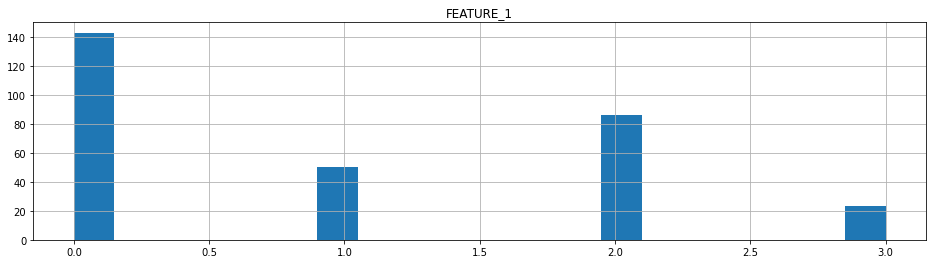

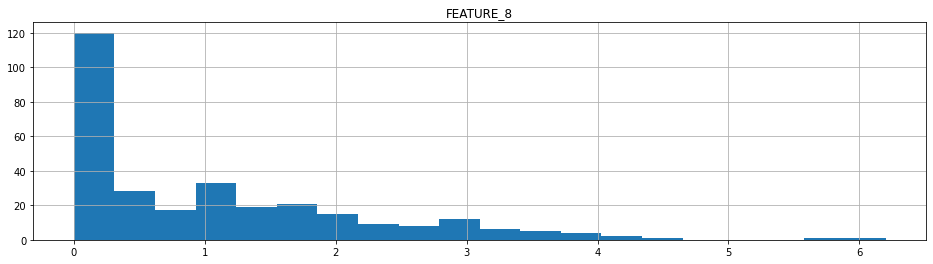

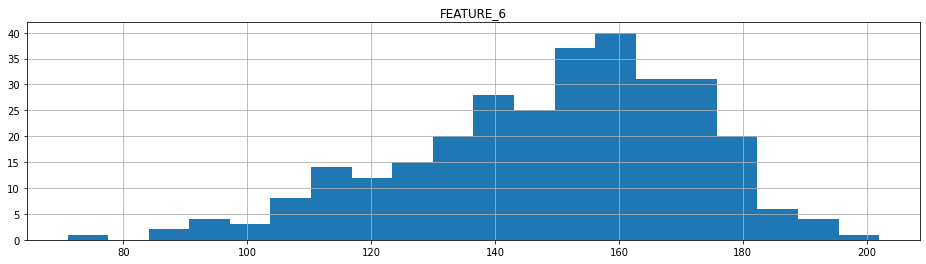

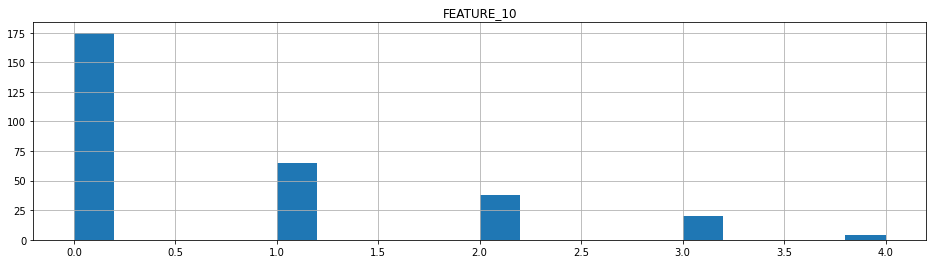

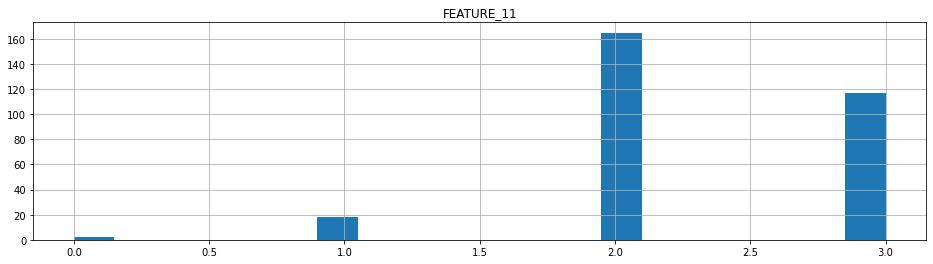

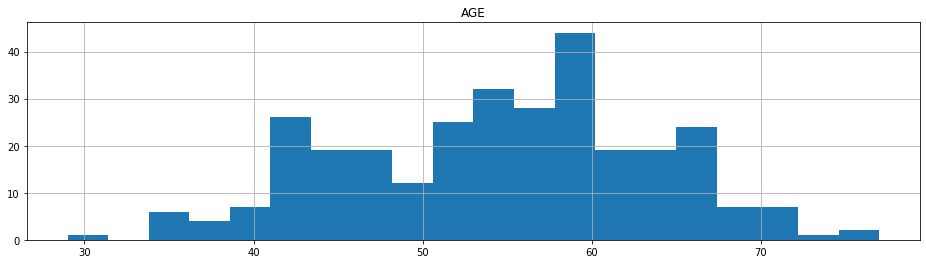

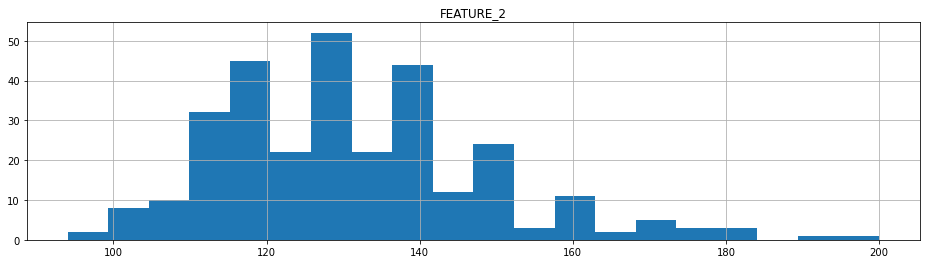

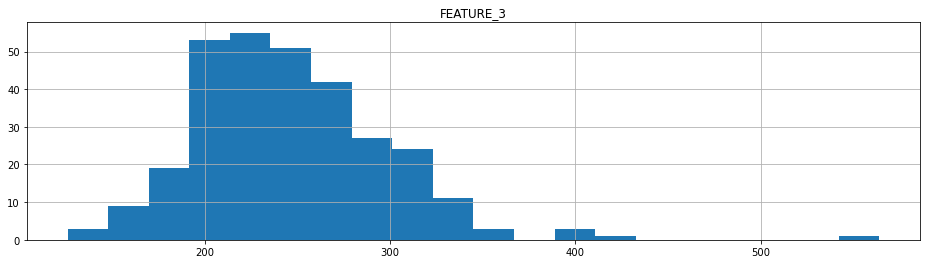

In [11]:
for col in num_cols:
    df[col].hist(bins=20)
    plt.title(col)
    plt.show()

Явных выбросов и аномалий на гистограммах не видно, хотя В FEATURE_3 и FEATURE_8 есть немного значений, лежащих в стороне от основного распределения. Не зная смысла признаков, объявлять эти значения выбросами и удалять/заменять их не рискну. FEATURE_8 и FEATURE_10 сильно скошены.  
Теперь посмотрим распределения для категориальных признаков

In [12]:
for col in bin_cols:
    print(df[col].value_counts())
    print()
    
for col in cat_cols:
    print(df[col].value_counts())
    print()

0    203
1     99
Name: FEATURE_7, dtype: int64

1    206
0     96
Name: GENDER, dtype: int64

0    257
1     45
Name: FEATURE_4, dtype: int64

2    141
1    140
0     21
Name: FEATURE_9, dtype: int64

1    151
0    147
2      4
Name: FEATURE_5, dtype: int64



### Подготовка выборок
Разделим датасет на фичи и таргет

In [13]:
X = df.drop(['TARGET'], axis=1)
y = df['TARGET']

Чтобы использовать линейные модели, сделаем one-hot кодирование для признаков, которые назначили категориальными

In [14]:
X_ohe = pd.get_dummies(X, columns=cat_cols, drop_first=True)
X_ohe

,AGE,GENDER,FEATURE_1,FEATURE_2,FEATURE_3,FEATURE_4,FEATURE_6,FEATURE_7,FEATURE_8,FEATURE_10,FEATURE_11,FEATURE_9_1,FEATURE_9_2,FEATURE_5_1,FEATURE_5_2
0,63,1,3,145,233,1,150,0,2.3,0,1,0,0,0,0
1,37,1,2,130,250,0,187,0,3.5,0,2,0,0,1,0
2,41,0,1,130,204,0,172,0,1.4,0,2,0,1,0,0
3,56,1,1,120,236,0,178,0,0.8,0,2,0,1,1,0
4,57,0,0,120,354,0,163,1,0.6,0,2,0,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
298,57,0,0,140,241,0,123,1,0.2,0,3,1,0,1,0
299,45,1,3,110,264,0,132,0,1.2,0,3,1,0,1,0
300,68,1,0,144,193,1,141,0,3.4,2,3,1,0,1,0
301,57,1,0,130,131,0,115,1,1.2,1,3,1,0,1,0


Разделим данные на обучающую и тестовую выборки. Тестовая - 20% от всех данных.

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print('Train:', X_train.shape, y_train.shape)
print('Test: ', X_test.shape, y_test.shape)

Train: (241, 13) (241,)
Test:  (61, 13) (61,)


In [16]:
X_train_ohe, X_test_ohe = train_test_split(X_ohe, test_size=0.2, random_state=42)
print('Train:', X_train_ohe.shape, y_train.shape)
print('Test: ', X_test_ohe.shape, y_test.shape)

Train: (241, 15) (241,)
Test:  (61, 15) (61,)


Масштабирование признаков для линейных моделей

In [17]:
scaler = StandardScaler()
X_train_ohe[num_cols] = scaler.fit_transform(X_train_ohe[num_cols])
X_test_ohe[num_cols] = scaler.transform(X_test_ohe[num_cols])
X_train_ohe

<ipython-input-17-440bd8970e46>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_ohe[num_cols] = scaler.fit_transform(X_train_ohe[num_cols])
C:\Users\albri\.conda\envs\python38\lib\site-packages\pandas\core\indexing.py:1738: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value[:, i].tolist(), pi)
<ipython-input-17-440bd8970e46>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value

,AGE,GENDER,FEATURE_1,FEATURE_2,FEATURE_3,FEATURE_4,FEATURE_6,FEATURE_7,FEATURE_8,FEATURE_10,FEATURE_11,FEATURE_9_1,FEATURE_9_2,FEATURE_5_1,FEATURE_5_2
132,-1.350641,1,0.000000,-0.630711,0.927138,0,0.549139,0,-0.895837,-0.683490,-0.545762,0,1,1,0
203,1.487426,1,0.966493,2.753363,0.526980,1,0.012071,1,0.543474,-0.683490,1.140502,1,0,0,0
197,1.378270,1,-0.966493,-0.348705,0.145878,1,0.593894,0,-0.715923,1.350103,1.140502,1,0,1,0
75,0.068393,0,0.000000,0.215308,0.069658,0,0.504383,0,0.363560,-0.683490,-0.545762,1,0,0,0
177,1.050801,1,0.966493,0.497314,1.689342,0,0.370116,0,-0.895837,-0.683490,-0.545762,0,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
189,-1.459797,1,-0.966493,-1.194723,-1.416640,0,0.370116,0,-0.895837,-0.683490,1.140502,0,1,0,0
71,-0.368233,1,0.966493,-2.097143,-0.368610,0,0.191094,1,-0.895837,0.333307,1.140502,0,1,1,0
106,1.596583,1,1.932986,1.625339,-0.235224,1,-0.838286,0,-0.805880,0.333307,-0.545762,1,0,0,0
271,0.723331,1,1.932986,0.158906,-0.235224,0,-0.211707,0,1.443044,1.350103,-0.545762,1,0,1,0


## Подбор моделей

Тут я загружаю библиотеку, которую написал ранее для визуализации подбора гиперпараметров с помощью GridSearchCV  
Код есть в моем репозитории на github

In [18]:
import sys  
sys.path.insert(0, 'C:\\Users\\albri\\Jupiter Workspace')
import albridge_lib as alb

#### Логистическая регрессия  
Бинарная классификация, маленький датасет - используем решатель liblinear. Проверим разные варианты регуляризации. Т.к. выборка маленькая, при кросс-валидации будем использовать 10 фолдов, это позволит получить более стабильные результаты.

Fitting 10 folds for each of 10 candidates, totalling 100 fits


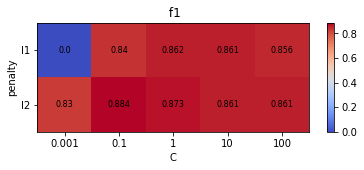

Best valid score: 0.884 (0.051)
Best params: {'C': 0.1, 'penalty': 'l2'}


,cv score,cv std,time
"{'C': 0.001, 'penalty': 'l1'}",0.000,0.000,0.005
"{'C': 0.001, 'penalty': 'l2'}",0.830,0.079,0.005
"{'C': 0.1, 'penalty': 'l1'}",0.840,0.058,0.005
"{'C': 0.1, 'penalty': 'l2'}",0.884,0.051,0.004
"{'C': 1, 'penalty': 'l1'}",0.862,0.047,0.004
"{'C': 1, 'penalty': 'l2'}",0.873,0.044,0.004
"{'C': 10, 'penalty': 'l1'}",0.861,0.047,0.004
"{'C': 10, 'penalty': 'l2'}",0.861,0.047,0.004
"{'C': 100, 'penalty': 'l1'}",0.856,0.053,0.006
"{'C': 100, 'penalty': 'l2'}",0.861,0.047,0.005


In [19]:
model = LogisticRegression(random_state=123, solver='liblinear')
params = {'C': [0.001,0.1,1,10,100], 'penalty': ['l1','l2']}
alb.sklearn_gridCV(model, X_train_ohe, y_train, 'f1', params, cv=10)

Проверим, дает ли что-нибудь балансировка классов

In [20]:
model = LogisticRegression(random_state=123, solver='liblinear', C=0.1)
params = {'class_weight': [None,'balanced']}
alb.sklearn_gridCV(model, X_train_ohe, y_train, 'f1', params, cv=10, plot=False)

Fitting 10 folds for each of 2 candidates, totalling 20 fits
Best valid score: 0.884 (0.051)
Best params: {'class_weight': None}


,cv score,cv std,time
{'class_weight': None},0.884,0.051,0.004
{'class_weight': 'balanced'},0.861,0.053,0.004


Результат с балансировкой хуже, чем без нее. Думаю, это говорит о том, что балансировка в данной задаче действительно не нужна, а разница скорее всего обусловлена распределением данных по фолдам.

#### SVC

Fitting 10 folds for each of 5 candidates, totalling 50 fits


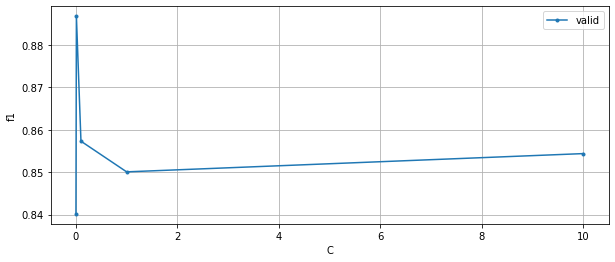

Best valid score: 0.887 (0.049)
Best params: {'C': 0.01}


,cv score,cv std,time
{'C': 0.001},0.840,0.071,0.006
{'C': 0.01},0.887,0.049,0.004
{'C': 0.1},0.857,0.042,0.005
{'C': 1},0.850,0.043,0.010
{'C': 10},0.854,0.048,0.013


In [21]:
model = LinearSVC(random_state=123)
params = {'C': [0.001,0.01,0.1,1,10]}
alb.sklearn_gridCV(model, X_train_ohe, y_train, 'f1', params, cv=10)

Fitting 10 folds for each of 10 candidates, totalling 100 fits


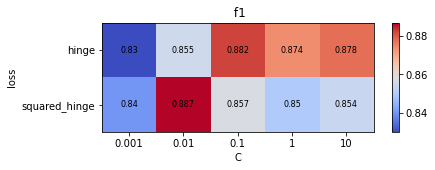

Best valid score: 0.887 (0.049)
Best params: {'C': 0.01, 'loss': 'squared_hinge'}


,cv score,cv std,time
"{'C': 0.001, 'loss': 'hinge'}",0.830,0.079,0.007
"{'C': 0.001, 'loss': 'squared_hinge'}",0.840,0.071,0.004
"{'C': 0.01, 'loss': 'hinge'}",0.855,0.059,0.004
"{'C': 0.01, 'loss': 'squared_hinge'}",0.887,0.049,0.004
"{'C': 0.1, 'loss': 'hinge'}",0.882,0.040,0.004
"{'C': 0.1, 'loss': 'squared_hinge'}",0.857,0.042,0.004
"{'C': 1, 'loss': 'hinge'}",0.874,0.045,0.005
"{'C': 1, 'loss': 'squared_hinge'}",0.850,0.043,0.009
"{'C': 10, 'loss': 'hinge'}",0.878,0.040,0.006
"{'C': 10, 'loss': 'squared_hinge'}",0.854,0.048,0.011


In [22]:
model = LinearSVC(random_state=123)
params = {'C': [0.001,0.01,0.1,1,10], 'loss': ['hinge', 'squared_hinge']}
alb.sklearn_gridCV(model, X_train_ohe, y_train, 'f1', params, cv=10)

#### kNN

Fitting 10 folds for each of 8 candidates, totalling 80 fits


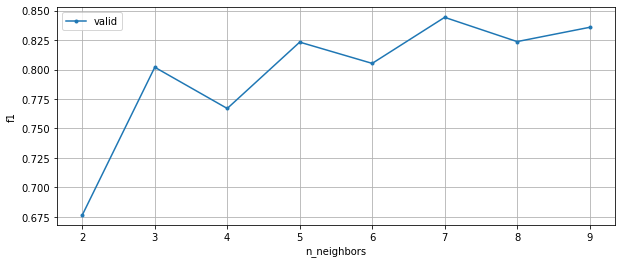

Best valid score: 0.844 (0.062)
Best params: {'n_neighbors': 7}


,cv score,cv std,time
{'n_neighbors': 2},0.677,0.147,0.004
{'n_neighbors': 3},0.802,0.063,0.004
{'n_neighbors': 4},0.767,0.108,0.004
{'n_neighbors': 5},0.823,0.064,0.003
{'n_neighbors': 6},0.805,0.074,0.003
{'n_neighbors': 7},0.844,0.062,0.004
{'n_neighbors': 8},0.824,0.081,0.004
{'n_neighbors': 9},0.836,0.060,0.004


In [23]:
model = KNeighborsClassifier()
params = {'n_neighbors': range(2,10)}
alb.sklearn_gridCV(model, X_train_ohe, y_train, 'f1', params, cv=10)

#### Случайный лес

Результат с гиперпараметрами по умолчанию с балансировкой и без

In [34]:
%%time
model = DecisionTreeClassifier(random_state=123)
params = {'class_weight': [None, 'balanced']}
alb.sklearn_gridCV(model, X_train, y_train, 'f1', params, plot=False)

Fitting 5 folds for each of 2 candidates, totalling 10 fits
Best valid score: 0.787 (0.071)
Best params: {'class_weight': 'balanced'}
Wall time: 96.4 ms


,cv score,cv std,time
{'class_weight': None},0.785,0.075,0.004
{'class_weight': 'balanced'},0.787,0.071,0.005


Подберём гиперпарамеры с помощью RandomizedSearchCV

In [25]:
%%time
model = RandomForestClassifier(random_state=123, n_jobs=-1)
distributions = dict(max_depth=randint(2,10), 
                     max_features=randint(2,X_train.shape[1]), 
                     class_weight=[None,'balanced'],
                     n_estimators=randint(10, 500))

rndsearch = RandomizedSearchCV(model, distributions, random_state=0, n_iter=50, scoring='f1', cv=10, verbose=1)
res = rndsearch.fit(X_train, y_train)
print(res.best_params_)
print(res.best_score_)

Fitting 10 folds for each of 50 candidates, totalling 500 fits
{'class_weight': None, 'max_depth': 7, 'max_features': 2, 'n_estimators': 497}
0.8575095645095645
Wall time: 2min 12s


#### Градиентный бустинг
Выборка очень маленькая, но попробовать все же стоит.  
Будем подбирать гиперпараметры последовательно, по два гиперпараметра за раз, начиная с наиболее значимых.
learning_rate сразу определим 0.05, кол-во итераций оставим по умолчанию - 100. Оптимальная сложность модели будет задана количеством листьев.

In [26]:
cat_col_idx = [list(X_train.columns).index(col) for col in cat_cols]
cat_col_idx

[10, 6]

Fitting 10 folds for each of 25 candidates, totalling 250 fits


C:\Users\albri\.conda\envs\python38\lib\site-packages\lightgbm\basic.py:1094: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  warnings.warn('{0} keyword has been found in `params` and will be ignored.\n'


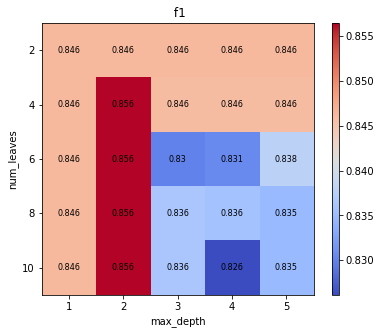

Best valid score: 0.856 (0.036)
Best params: {'max_depth': 2, 'num_leaves': 4}


In [27]:
model = lgb.LGBMClassifier(objective='binary', random_state=123, learning_rate=0.05, categorical_feature=cat_col_idx)
params = {'num_leaves': range(2,12,2), 'max_depth': range(1,6)}
res = alb.sklearn_gridCV(model, X_train, y_train, 'f1', params, cv=10)

Fitting 10 folds for each of 25 candidates, totalling 250 fits


C:\Users\albri\.conda\envs\python38\lib\site-packages\lightgbm\basic.py:1094: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  warnings.warn('{0} keyword has been found in `params` and will be ignored.\n'


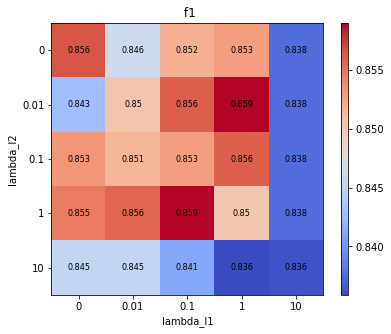

Best valid score: 0.859 (0.033)
Best params: {'lambda_l1': 0.1, 'lambda_l2': 1}


In [28]:
model = lgb.LGBMClassifier(objective='binary', 
                           random_state=123, 
                           learning_rate=0.05,
                           categorical_feature=cat_col_idx,
                           num_leaves=4,
                           max_depth=2)
params = {'lambda_l1': [0, 0.01, 0.1, 1, 10], 'lambda_l2': [0, 0.01, 0.1, 1, 10]}
res = alb.sklearn_gridCV(model, X_train, y_train, 'f1', params, cv=10)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


C:\Users\albri\.conda\envs\python38\lib\site-packages\lightgbm\basic.py:1094: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  warnings.warn('{0} keyword has been found in `params` and will be ignored.\n'


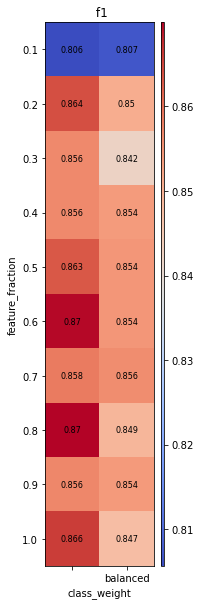

Best valid score: 0.870 (0.026)
Best params: {'class_weight': None, 'feature_fraction': 0.8}


In [29]:
model = lgb.LGBMClassifier(objective='binary', 
                           random_state=123, 
                           learning_rate=0.05,
                           categorical_feature=cat_col_idx,
                           num_leaves=4,
                           max_depth=2,
                           lambda_l1=0.1)
params = {'feature_fraction': np.arange(0.1, 1.01, 0.1).round(2), 'class_weight': [None, 'balanced']}
res = alb.sklearn_gridCV(model, X_train, y_train, 'f1', params)

До результата логистической регрессии так и не дотянули.

### Тестирование модели

Логистическая регрессия и SVC показали лучший результат на кросс-валидации, SVC чуть-чуть получше. Обучим SVC на всей обучающей выборке, проверим результат на тестовой.

In [30]:
model = LinearSVC(random_state=123, loss='squared_hinge', C=0.01)
model.fit(X_train_ohe, y_train)
pred = model.predict(X_test_ohe)
np.round(f1_score(y_test, pred),5)

0.89231

Матрица ошибок

In [31]:
confusion_matrix(y_test, pred)

array([[25,  4],
       [ 3, 29]], dtype=int64)

Коэффициенты признаков

In [32]:
fi = pd.DataFrame(index=X_train_ohe.columns, data={'coef': model.coef_[0], 'abs_coef': abs(model.coef_[0])})
fi.sort_values('abs_coef', ascending=False)

,coef,abs_coef
FEATURE_10,-0.211455,0.211455
FEATURE_11,-0.193211,0.193211
FEATURE_1,0.191652,0.191652
GENDER,-0.190632,0.190632
FEATURE_8,-0.170494,0.170494
FEATURE_9_2,0.169630,0.169630
FEATURE_7,-0.162505,0.162505
FEATURE_6,0.136547,0.136547
FEATURE_5_1,0.123962,0.123962
FEATURE_2,-0.097876,0.097876


Сравним с результатом фиктивного классификатора

In [33]:
dummy_clf = DummyClassifier(strategy="most_frequent")
dummy_clf.fit(X_train, y_train)
pred = dummy_clf.predict(X_test)
np.round(f1_score(y_test, pred),5)

0.68817

Результат модели на тестовой выборке лучше, чем у фиктивного классификатора, что подтверждает ее адекватность.  

Возможные направления для дальнейшего исседования: 
- попробовать другое разделение признаков между категориальными и количествеными 
- убрать смещение в распределении количественых признаков